In [4]:
import mlflow
import mlflow.pytorch
from contextlib import nullcontext

import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from datasets import DatasetA, DatasetB, cfg
from datasets.base import collate_bb
from datasets.augmentation import augment_batch

NUM_EPOCHS    = 1
BATCH_SIZE    = 4
NUM_WORKERS   = 4
LR            = 0.005
WEIGHT_DECAY  = 1e-4

HFLIP_P       = 0.5
COLOR_P       = 0.3
PRINT_EVERY   = 50

EXPERIMENT_NAME = "karyotest"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = cfg.num_classes
val_fraction = 0.1

mlflow.set_tracking_uri("file:///media/sdb1/mlflow")

In [5]:
ds_a = DatasetA(cfg.root_a_xml, cfg.root_a_img, cfg.label_map, cfg.max_size, num_channels=3) #we need 3 channels for maskrcnn
ds_b_full_train = DatasetB(cfg.root_b, "train", cfg.label_map, cfg.max_size, num_channels=3)

n_val = int(len(ds_b_full_train) * val_fraction)
n_train = len(ds_b_full_train) - n_val

ds_b_train, ds_b_val = random_split(
    ds_b_full_train,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42),
)

train_ds =ds_b_train  #ConcatDataset([ds_a, ds_b_train])

def make_dataloaders(batch_size=4, num_workers=4):
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_bb,
    )

    val_loader = DataLoader(
        ds_b_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_bb,
    )
    return train_loader, val_loader


def make_model():
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

    return model


def to_device(images, targets, device):
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

In [6]:
model = make_model().to(device)

In [7]:
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(loader, 1):
        images, targets = augment_batch(images, targets)
        images, targets = to_device(images, targets, device)

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step % PRINT_EVERY == 0 or step == len(loader):
            print(
                f"[Epoch {epoch + 1}/{NUM_EPOCHS}] "
                f"Step {step}/{len(loader)} "
                f"Loss {loss.item():.4f}"
            )

    epoch_loss = running_loss / len(loader)
    print(f"[Epoch {epoch + 1}/{NUM_EPOCHS}] Train loss: {epoch_loss:.4f}")
    return epoch_loss

def eval_one_epoch(model, loader):
    model.train()
    running_loss = 0.0

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            running_loss += losses.item()

    return running_loss / len(loader)



def run_training(num_epochs=NUM_EPOCHS):
    train_loader, val_loader = make_dataloaders(batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)
    
    
    params = [p for p in model.parameters() if p.requires_grad] #i think we pass only trainable to optimizer?
    optimizer = torch.optim.SGD(params,lr=LR,momentum=0.9, weight_decay=WEIGHT_DECAY)
    history = {"train_loss": [], "val_loss": []}
    mlflow.set_experiment(EXPERIMENT_NAME)
    run_ctx = mlflow.start_run()

    with run_ctx:
        mlflow.log_params({
            "batch_size": BATCH_SIZE,
            "lr": LR,
            "weight_decay": WEIGHT_DECAY,
            "num_epochs": num_epochs,
        })

        for epoch in range(num_epochs):
            train_loss = train_one_epoch(
                model,
                train_loader,
                optimizer,
                epoch,
            )
            val_loss = eval_one_epoch(model, val_loader)
            print(f"[Epoch {epoch + 1}/{num_epochs}] Val loss: {val_loss:.4f}")

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.pytorch.log_model(model, "model")

    return model, history

In [ ]:
run_training(num_epochs = 10)

In [14]:
torch.save(model.state_dict(), "maskrcnn_karyo_test.pth")

In [14]:
import numpy as np

from train.metrics import get_metrics
from train.plotting import plot_predictions


def eval_test_B(model):
    test_ds = DatasetB(cfg.root_b, "test", cfg.label_map, cfg.max_size, num_channels = 3)
    test_loader = DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_bb,
    )

    preds, targs = [], []
    model.eval()

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for out, gt in zip(outputs, targets):
                out = {k: v.cpu() for k, v in out.items()}
                gt = {k: (v.cpu() if torch.is_tensor(v) else v) for k, v in gt.items()}

                # masks -> numpy [N, H, W] for PQ / AJI
                if "masks" in out:
                    m = out["masks"]
                    if m.ndim == 4:          # [N,1,H,W] -> [N,H,W]
                        m = m[:, 0]
                    out["masks"] = (m > 0.5).byte().numpy()

                if "masks" in gt:
                    gt["masks"] = gt["masks"].numpy().astype(np.uint8)

                preds.append(out)
                targs.append(gt)

    num_classes = max(cfg.label_map.values())  # 24
    metrics_B = get_metrics(preds, targs, num_classes=num_classes)
    return metrics_B, test_ds


{'mAP50': 0.09225074201822281, 'PQ_all': 0.17822167354481572, 'mPQ': 0.13713033082647294, 'PQ_per_class': array([0.39929271, 0.28404735, 0.18533844, 0.19368557, 0.15342779,
       0.16859716, 0.05896173, 0.09807083, 0.10547237, 0.06810013,
       0.16220595, 0.        , 0.08780139, 0.        , 0.16729328,
       0.22784936, 0.05313735, 0.11156547, 0.16347109, 0.20401594,
       0.19027561, 0.20851843, 0.        , 0.        ]), 'AJI': 0.28096917089593887}


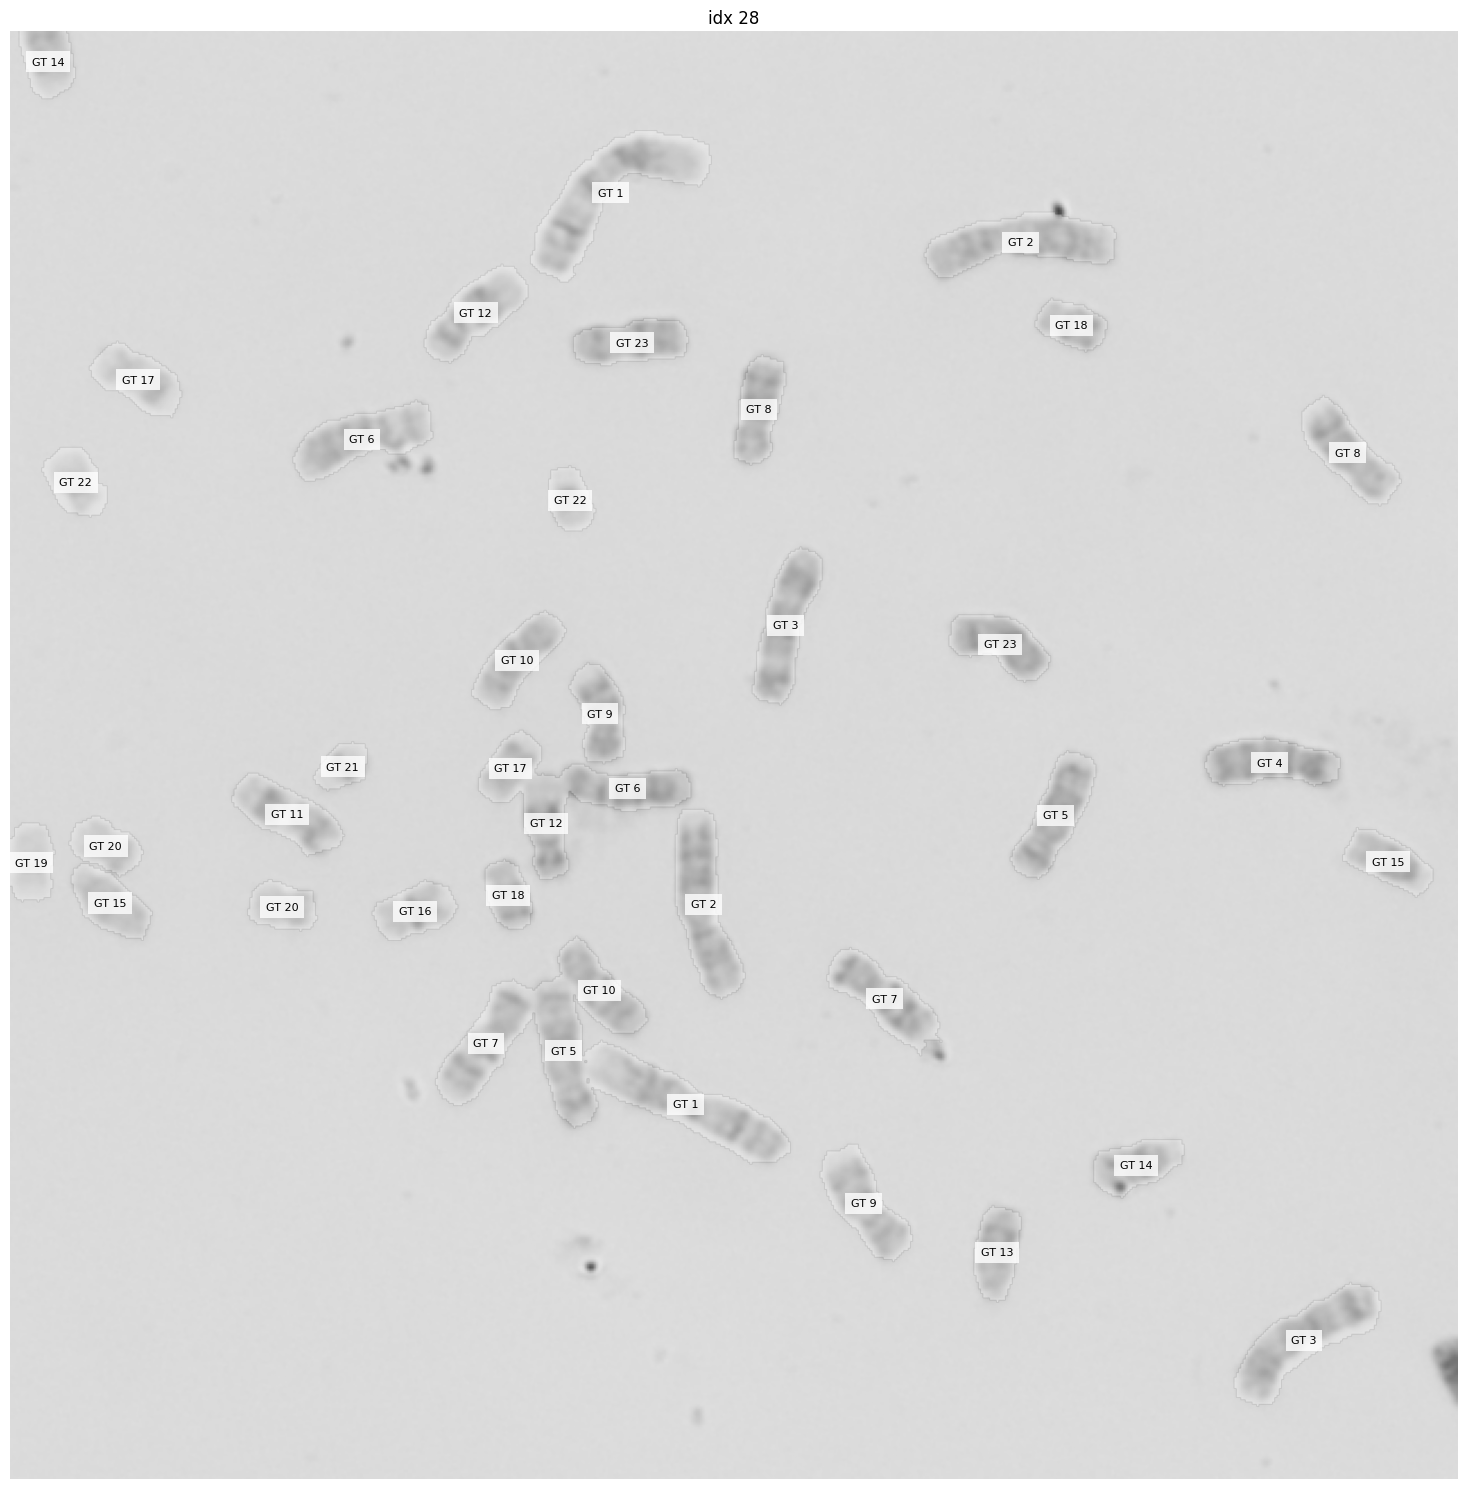

In [15]:
metrics_B, ds_b_test = eval_test_B(model)
print(metrics_B)

# one image with masks + IDs
plot_predictions(ds_b_test, model, device, n=1, score_thresh=0.5)